In [ ]:
import os
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

In [3]:
def bbox_intersection(bbox_1, bbox_2):
    m_w = 0
    m_h = 0
    if (bbox_1[0] < bbox_2[0]):
        m_w = max(min(bbox_1[0] + bbox_1[2] - bbox_2[0], bbox_2[2]), 0)
    else:
        m_w = max(min(bbox_2[0] + bbox_2[2] - bbox_1[0], bbox_1[2]), 0)
    if (bbox_1[1] < bbox_2[1]):
        m_h = max(min(bbox_1[1] + bbox_1[3] - bbox_2[1], bbox_2[3]), 0)
    else:
        m_h = max(min(bbox_2[1] + bbox_2[3] - bbox_1[1], bbox_1[3]), 0)
    intersection = m_w * m_h
    return intersection

def ios(bbox_1, bbox_2):
    intersection = bbox_intersection(bbox_1, bbox_2)
    smaller_bbox_area = min(bbox_1[2] * bbox_1[3], bbox_2[2] * bbox_2[3])
    
    if intersection > smaller_bbox_area:
        print("Error in ios function")
        print(intersection, smaller_bbox_area)
        
    if smaller_bbox_area > 0:
        ios = intersection / smaller_bbox_area
    else:
        ios = 0
    return ios

In [4]:
def get_crops(
        image_full_path,
        imgsz=1024,
        overlap_x=20,
        overlap_y=20,
        max_crops_x=4,
        max_crops_y=4,
        bboxes=None,
        rect_mode=True,
        show=False,
        save=False,
        save_path='./',
        save_name='crop',
    ):
        shape_x = imgsz
        shape_y = imgsz
        image_full = Image.open(image_full_path)
        image_x, image_y = image_full.size
        cross_koef_x = 1 - (overlap_x / 100)
        cross_koef_y = 1 - (overlap_y / 100)
        max_image_size_x = (max_crops_x - 1) * (shape_x * cross_koef_x) + shape_x
        max_image_size_y = (max_crops_y - 1) * (shape_y * cross_koef_y) + shape_y
        if rect_mode:
            if image_x > image_y:
                r = max_image_size_x / image_x
                if r < 1:
                    image_x, image_y = (min(math.ceil(image_x * r), max_image_size_x), min(math.ceil(image_y * r), max_image_size_x))
                r = max_image_size_y / image_y
                if r < 1:
                    image_x, image_y = (min(math.ceil(image_x * r), max_image_size_y), min(math.ceil(image_y * r), max_image_size_y))
            else:
                r = max_image_size_y / image_y
                if r < 1:
                    image_x, image_y = (min(math.ceil(image_x * r), max_image_size_y), min(math.ceil(image_y * r), max_image_size_y))
                r = max_image_size_x / image_x
                if r < 1:
                    image_x, image_y = (min(math.ceil(image_x * r), max_image_size_x), min(math.ceil(image_y * r), max_image_size_x))
        else:
            image_x, image_y = (min(image_x, max_image_size_x), min(image_y, max_image_size_y))
        
        overlap_x = max(0, min(int(overlap_x), 100))
        overlap_y = max(0, min(int(overlap_y), 100))
        
        x_steps = min(round(max((image_x - shape_x), 0) / (shape_x * cross_koef_x)) + 1, max_crops_x)
        y_steps = min(round(max((image_y - shape_y), 0) / (shape_y * cross_koef_y)) + 1, max_crops_y)

        x_new = int((x_steps-1) * (shape_x * cross_koef_x) + shape_x)
        y_new = int((y_steps-1) * (shape_y * cross_koef_y) + shape_y)
        
        if x_new > max_image_size_x or y_new > max_image_size_y:
            print('Error')
            return
        
        image_full = image_full.resize((x_new, y_new))

        if show:
            plt.figure(figsize=[x_steps*5, y_steps*5])
        
        count = 0
        for i in range(y_steps):
            for j in range(x_steps):
                x_start = int(shape_x * j * cross_koef_x)
                y_start = int(shape_y * i * cross_koef_y)

                if x_start + shape_x > x_new:
                    print('Error in generating crops along the x-axis')
                    continue
                if y_start + shape_y > y_new:
                    print('Error in generating crops along the y-axis')
                    continue
                
                c_bboxes = []
                for bbox in bboxes:
                    c, x, y, w, h = bbox
                    if (ios([x - w / 2, y - h / 2, w, h], [x_start / x_new, y_start / y_new, shape_x / x_new, shape_y / y_new])) > 0.5:
                        c_bbox = [c,
                                  max((x - w / 2 - x_start / x_new) * x_new / shape_x, 0),
                                  max((y - h / 2 - y_start / y_new) * y_new / shape_y, 0),
                                  min((x + w / 2 - x_start / x_new) * x_new / shape_x, 1),
                                  min((y + h / 2 - y_start / y_new) * y_new / shape_y, 1)]
                        c_bbox = [c,
                                  c_bbox[1] + (c_bbox[3] - c_bbox[1]) / 2,
                                  c_bbox[2] + (c_bbox[4] - c_bbox[2]) / 2,
                                  c_bbox[3] - c_bbox[1],
                                  c_bbox[4] - c_bbox[2]]
                        c_bboxes.append(c_bbox)
                
                im_temp = image_full.crop((x_start, y_start, x_start + shape_x, y_start + shape_y))
                im_temp_x, im_temp_y = im_temp.size
                if (im_temp_x != shape_x or im_temp_y != shape_y):
                        im_temp = im_temp.resize((shape_x, shape_y))
                        
                if show:
                    cv_im_temp= np.array(im_temp)
                    for c_bbox in c_bboxes:
                        cv2.rectangle(cv_im_temp, [int((c_bbox[1] - c_bbox[3] / 2) * cv_im_temp.shape[1]), int((c_bbox[2] - c_bbox[4] / 2) * cv_im_temp.shape[0])], 
                                  [int((c_bbox[1] + c_bbox[3] / 2) * cv_im_temp.shape[1]), int((c_bbox[2] + c_bbox[4] / 2) * cv_im_temp.shape[0])], (255, 0, 0), 1)
                    plt.subplot(y_steps, x_steps, i * x_steps + j + 1)
                    plt.imshow(cv_im_temp)
                    plt.axis('off')
                    
                if save:
                    empty_crop_tresh = 1 / (x_steps * 2)
                    if not os.path.exists(save_path):
                        os.makedirs(save_path)
                        os.makedirs(save_path + '/images')
                        os.makedirs(save_path + '/labels')
                    filename_img = f"{save_path}/images/{save_name}_{count}.jpg"
                    filename_label = f"{save_path}/labels/{save_name}_{count}.txt"
                    if (len(c_bboxes) > 0):
                        im_temp.save(filename_img)
                        label_file = open(filename_label, 'w')
                        for c_bbox in c_bboxes:
                            label_file.write(f"{int(c_bbox[0])} {c_bbox[1]} {c_bbox[2]} {c_bbox[3]} {c_bbox[4]}\n")
                        label_file.close()
                    else:
                        rand = np.random.rand()
                        if (rand < empty_crop_tresh):
                            im_temp.save(filename_img)
                
                count += 1 ###
              
        image_full.close()
        
        if show:
            plt.show()
            
        return

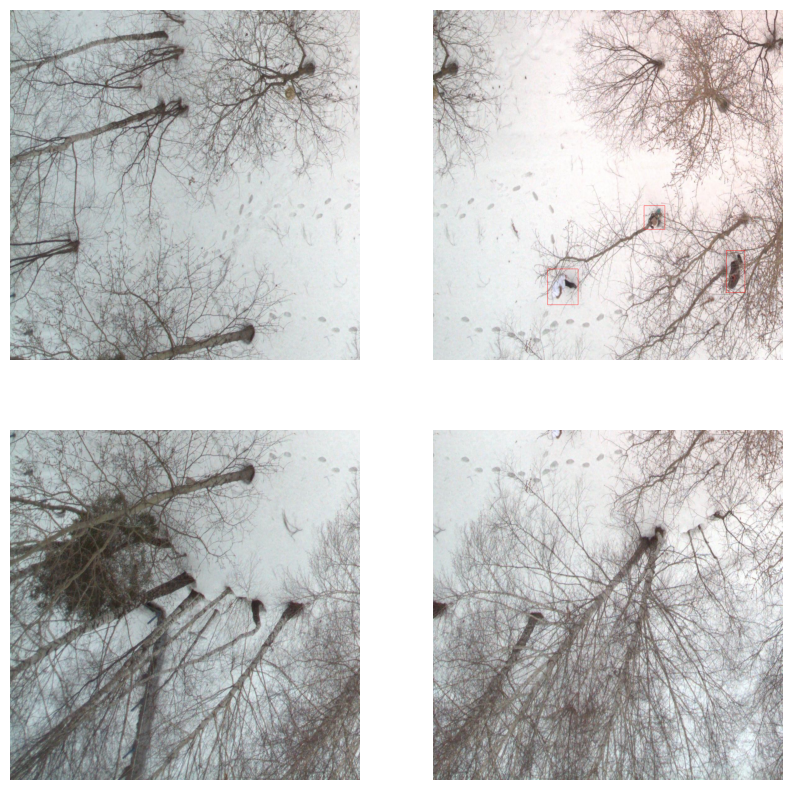

In [ ]:
image_path = './120877.jpg'

bbox_file = open('./120877.txt', 'r')
bboxes = []
for line in bbox_file.readlines():
    if (len(line.split()) == 5):
        bbox = [float(i) for i in line.split()]
        bboxes.append(bbox)
bbox_file.close()

get_crops(image_path, imgsz=1024, overlap_x=20, overlap_y=20, max_crops_x=10, max_crops_y=10, bboxes=bboxes, show=True, save=False)

In [ ]:
input_path = './data_path'
save_path = './path_save'

for file in tqdm(os.listdir(input_path + '/images')):
    filename_without_ext = os.path.splitext(file)[0]
    label_path = os.path.join(input_path, 'labels', filename_without_ext + '.txt')
    
    if not os.path.exists(label_path):
        print(f"Файл меток не найден: {label_path}")
        continue 
    
    frame_path = os.path.join(input_path, 'images', file)
    with open(label_path, 'r') as bbox_file:
        bboxes = []
        for line in bbox_file:
            if len(line.strip().split()) == 5:
                bbox = [float(i) for i in line.strip().split()]
                bboxes.append(bbox)
    bbox_file.close()
    data_all_crops = get_crops(frame_path, imgsz=1024, overlap_x=20, overlap_y=20, 
                               max_crops_x=10, max_crops_y=10, 
                               bboxes=bboxes, save=True, save_path=save_path, save_name=file.split('.')[0])

 43%|███████████████████████████████████                                              | 217/501 [01:09<01:31,  3.12it/s]

Файл меток не найден: /home/aerozrenie/second_stage/close_Val/labels/.ipynb_checkpoints.txt


100%|█████████████████████████████████████████████████████████████████████████████████| 501/501 [02:38<00:00,  3.15it/s]
